# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer-learning: fine-tuning

## Creating helper functions

In previous notebooks, we have created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you will want to use again in a script you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions we have used previously.

In [1]:
import sys
import os

# Subir dos niveles: desde notebooks/pruebas → mi_proyecto/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Ahora puedes importar
from utils.helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get some data

This time we are going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [2]:
# Get 10% of training data of 10% of Food101 and check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = "10_food_classes_10_percent/test"

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# See and example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[150.0153     154.68367    153.03061   ]
   [158.19897    155.4847     146.69897   ]
   [113.86734    108.36224     90.87755   ]
   ...
   [121.35185    115.994644    80.637436  ]
   [119.90825    107.83681     67.6429    ]
   [130.76016    115.2755      71.688705  ]]

  [[ 89.82143     90.89285     85.39796   ]
   [106.07141    104.219376    92.37243   ]
   [ 50.08162     46.913254    29.969378  ]
   ...
   [110.83145    107.64259     72.87216   ]
   [113.88263    104.464226    65.448906  ]
   [119.566635   107.4952      66.63799   ]]

  [[ 41.071426    36.642857    25.42857   ]
   [ 42.811222    38.38265     25.954077  ]
   [ 26.811224    23.239798    11.071429  ]
   ...
   [111.81114    109.45393     76.23967   ]
   [110.673386   105.703964    67.84681   ]
   [105.34713     98.27063     58.48992   ]]

  ...

  [[ 18.214264    15.214264    10.214264  ]
   [ 16.84186     14.270388     9.270388  ]
   [ 16.16835     15.260178    10.42855   ]
   ...
   [ 33.004913    16.550

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [8]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), # validate on a quarter
                                 callbacks=create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='10_percent_feature_extraction'))

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250728-221059
Epoch 1/5
24/24 [==============================] - 16s 127ms/step - loss: 1.9466 - accuracy: 0.3467 - val_loss: 1.3641 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 2s 84ms/step - loss: 1.1834 - accuracy: 0.7320 - val_loss: 0.9052 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 2s 85ms/step - loss: 0.8606 - accuracy: 0.8107 - val_loss: 0.7083 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 2s 82ms/step - loss: 0.7026 - accuracy: 0.8360 - val_loss: 0.5945 - val_accuracy: 0.8783
Epoch 5/5
24/24 [==============================] - 2s 82ms/step - loss: 0.5942 - accuracy: 0.8693 - val_loss: 0.5333 - val_accuracy: 0.8766


In [9]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 4s 43ms/step - loss: 0.5777 - accuracy: 0.8532


[0.5777068734169006, 0.8532000184059143]

In [10]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [11]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [12]:
# How about a summary of our model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


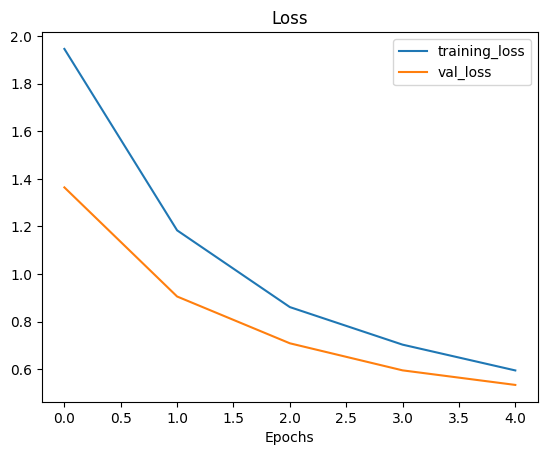

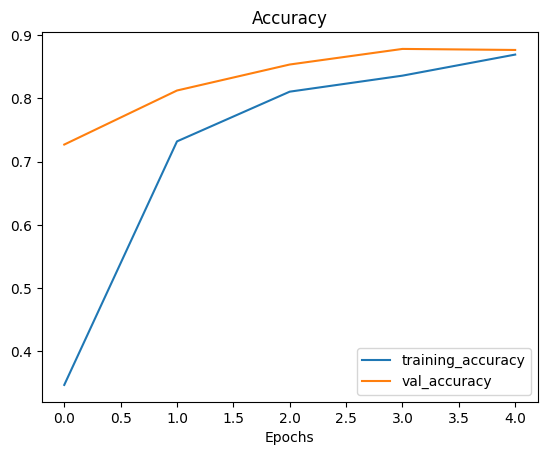

In [13]:
# Check out our model's training curves
plot_loss_curves(history=history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [14]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
gloabl_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global Average Pooled Random Tensor:\n {gloabl_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensors: {input_tensor.shape}')
print(f'Shape og 2D Global Average Pooled Tensor: {gloabl_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Average Pooled Random Tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensors: (1, 4, 4, 3)
Shape og 2D Global Average Pooled Tensor: (1, 3)


In [15]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained models outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model 1

In [16]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [17]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [18]:
# Setup data loaders
IMF_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.layers.experimental import preprocessing # type: ignore

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2
], name='data_augmentation')

### Visualize our data augmentation layer and see what happens to our data

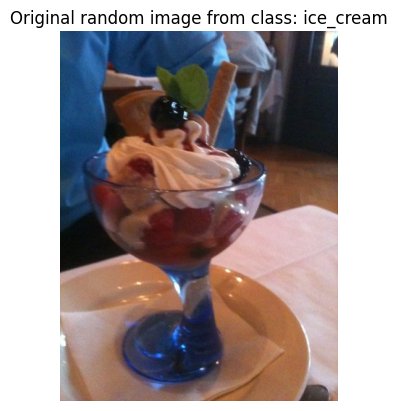

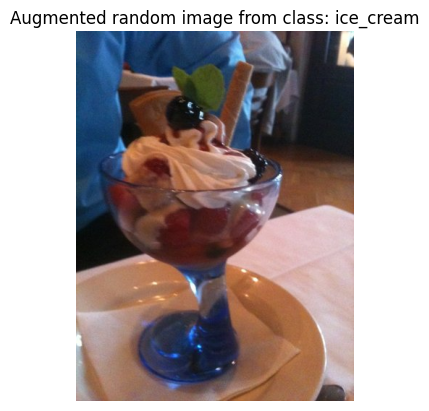

In [20]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class: {target_class}')
plt.axis('off')
plt.show()

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis('off');

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [21]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='gloabl_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250728-221131
Epoch 1/5
3/3 [==============================] - 9s 1s/step - loss: 2.4260 - accuracy: 0.1000 - val_loss: 2.2288 - val_accuracy: 0.2122
Epoch 2/5
3/3 [==============================] - 2s 600ms/step - loss: 2.1386 - accuracy: 0.2429 - val_loss: 2.1120 - val_accuracy: 0.2961
Epoch 3/5
3/3 [==============================] - 2s 626ms/step - loss: 1.9944 - accuracy: 0.4143 - val_loss: 2.0084 - val_accuracy: 0.3553
Epoch 4/5
3/3 [==============================] - 1s 607ms/step - loss: 1.8374 - accuracy: 0.4571 - val_loss: 1.9117 - val_accuracy: 0.4326
Epoch 5/5
3/3 [==============================] - 1s 581ms/step - loss: 1.6981 - accuracy: 0.5429 - val_loss: 1.8241 - val_accuracy: 0.4836


In [22]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 gloabl_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [23]:
# Evaluate on the full test set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 3s 42ms/step - loss: 1.8359 - accuracy: 0.4568


[1.835925579071045, 0.45680001378059387]

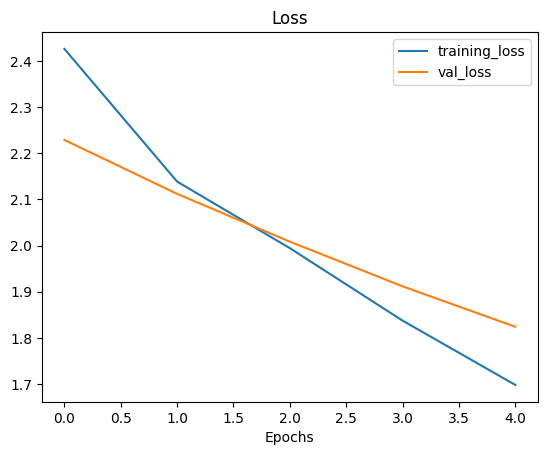

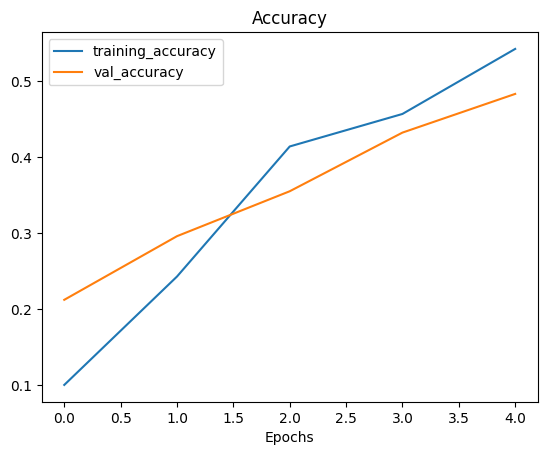

In [24]:
# How does the model go with data augmentation on the loss curves?
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% of data with data augmentation

In [25]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [26]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
# How many images are in our directories?
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [28]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in beteween)
inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to our base model
x = layers.GlobalAveragePooling2D(name='gloabl_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weigths) during training. This is useful so we can come and start where we left oft.

In [29]:
# Set checkpoint path
checkpoint_path = '10_percent_model_checkpoint_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [30]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                 experiment_name='10_percent_data_aug'),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250728-223424
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9982 - accuracy: 0.3427
Epoch 1: saving model to 10_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 15s 320ms/step - loss: 1.9982 - accuracy: 0.3427 - val_loss: 1.4725 - val_accuracy: 0.6217
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3800 - accuracy: 0.6640
Epoch 2: saving model to 10_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 7s 275ms/step - loss: 1.3800 - accuracy: 0.6640 - val_loss: 1.0570 - val_accuracy: 0.7336
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.7093
Epoch 3: saving model to 10_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 7s 275ms/step - loss: 1.1028 - accuracy: 0.7093 - val_loss: 0.8749 - val_accuracy: 0.7632
Epoch 4/5

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 4s 40ms/step - loss: 0.5777 - accuracy: 0.8532


[0.5777068734169006, 0.8532000184059143]

In [33]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 4s 40ms/step - loss: 0.6532 - accuracy: 0.8240


[0.6531964540481567, 0.8240000009536743]

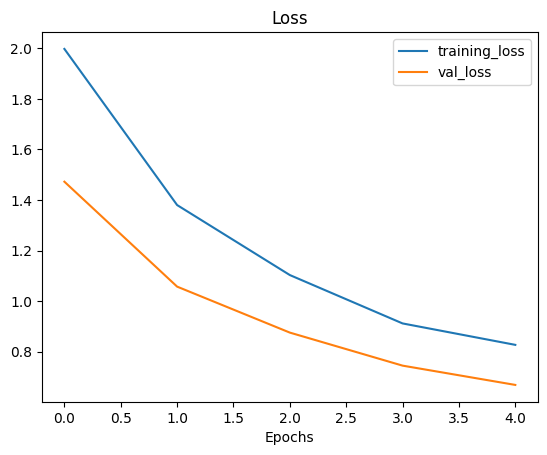

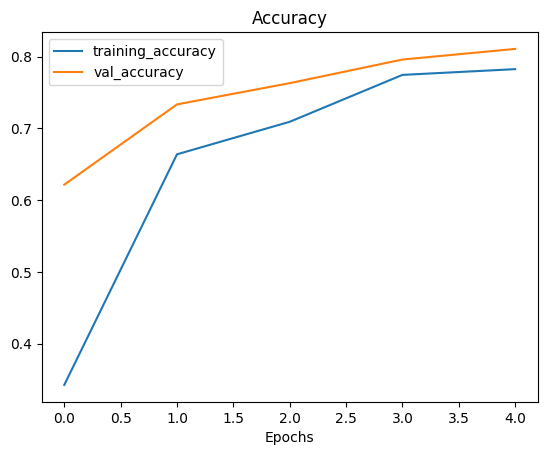

In [34]:
# Plot model loss curves
plot_loss_curves(history=history_10_percent_data_aug)

### Loading in checkpointed weigths

Loading in checkpointed weigths returns a model to a specific checkpoint.

In [35]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [36]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 4s 40ms/step - loss: 0.6532 - accuracy: 0.8240


In [37]:
# If the results from our previously evaluated model_2 match the loaded weights, every
results_10_percent_data_aug == loaded_weights_model_results

False

In [38]:
results_10_percent_data_aug

[0.6531964540481567, 0.8240000009536743]

In [39]:
loaded_weights_model_results

[0.6531965136528015, 0.8240000009536743]